In [71]:
import os 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Creating tf dataset

In [72]:
dataset_dir = "./Skin cancer ISIC The International Skin Imaging Collaboration/"

train_dir = os.path.join(dataset_dir,'Train')
test_dir = os.path.join(dataset_dir,'Test')
BATCH_SIZE = 32

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256


train_dataset = tf.keras.utils.image_dataset_from_directory( directory= train_dir,
                                                             shuffle= True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= (IMAGE_HEIGHT,IMAGE_WIDTH),
                                                            seed= 142)

test_dataset = tf.keras.utils.image_dataset_from_directory( directory= test_dir,
                                                             shuffle= True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= (IMAGE_HEIGHT,IMAGE_WIDTH),
                                                            seed= 142)
                                                        

Found 2239 files belonging to 9 classes.
Found 118 files belonging to 9 classes.


In [73]:
class_names = train_dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

## Let's visualize images we have

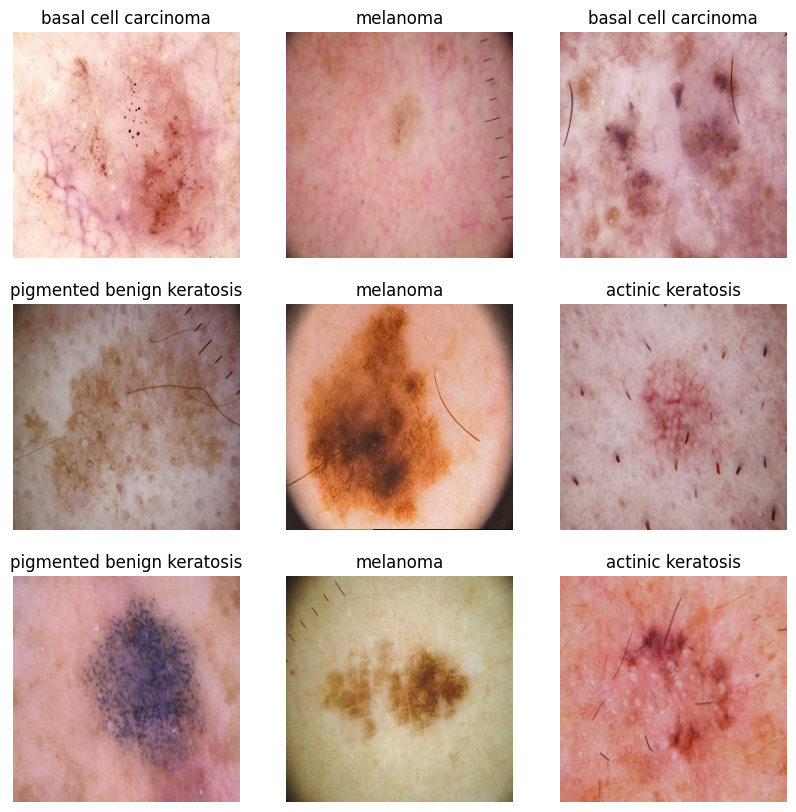

In [74]:
plt.figure(figsize=(10,10))

# NOTE : dataset.take(1) results one batch of (images,labels)
for images,labels in train_dataset.take(1):
     for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint16))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    

## Resizing and rescaling images

In [94]:
preprocessing_layer = tf.keras.Sequential([
        tf.keras.layers.Resizing(IMAGE_HEIGHT,IMAGE_WIDTH),
        tf.keras.layers.Rescaling(1./255),      
])

# Augmenting Image

In [97]:
augmentation_layer = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

## Lets visualize an augmented image

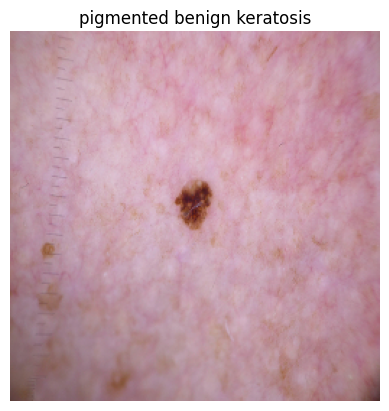

In [102]:
random_i = tf.keras.random.randint((),0,len(images))
test_image = images[random_i].numpy().astype(np.uint16)
plt.imshow(test_image)
plt.title(class_names[labels[random_i]])
plt.axis('off')
plt.show()

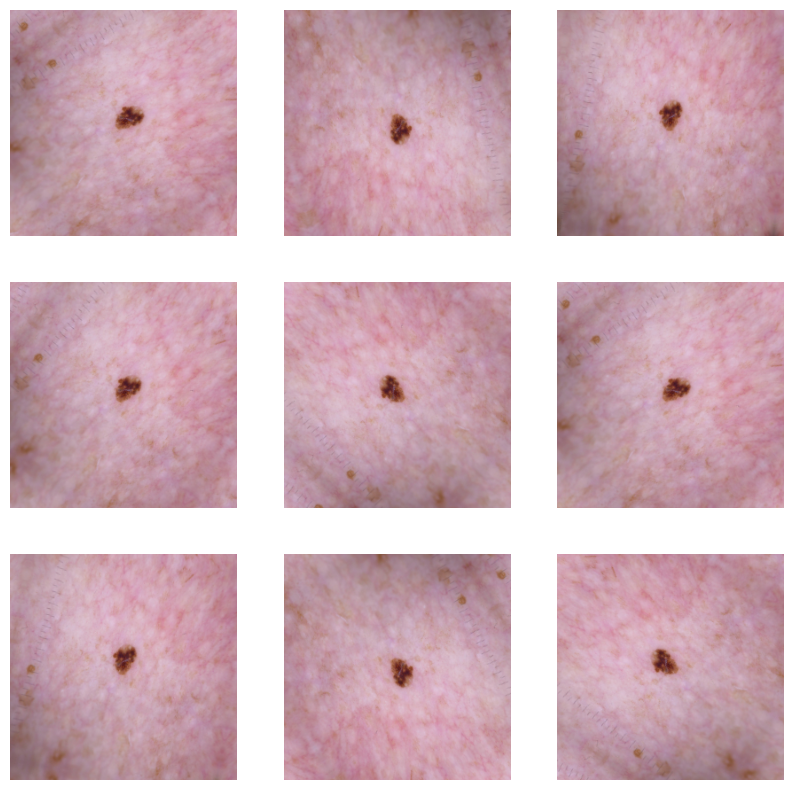

In [103]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augmentation_layer(tf.expand_dims(test_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Using buffered prefetching, helps you yield data from disk without having I/O become blocking.

In [104]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 
test_dataset= test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Defining the model

In [144]:
class Model_1(tf.keras.Model):

    def __init__(self, number_of_classes : int ):
        super().__init__()
        self.conv_layer1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.conv_layer2 = tf.keras.layers.Conv2D(64, 3, activation='relu')
        self.conv_layer3 = tf.keras.layers.Conv2D(128, 3, activation='relu')
        
        self.max_pool_layer = tf.keras.layers.MaxPool2D()
        self.flatten_layer = tf.keras.layers.Flatten()
        self.dense_mid = tf.keras.layers.Dense(128,activation="relu")
        self.output_dense = tf.keras.layers.Dense(number_of_classes)
        

    def call(self, x):

        x = resize_and_rescale(x)
        x = data_augmentation(x)
        
        # First Convolution
        x = self.conv_layer1(x)
        x = self.max_pool_layer(x)

        # Second Convolution
        x = self.conv_layer2(x)
        x = self.max_pool_layer(x)
        
        # Third Convolution
        x = self.conv_layer3(x)
        x = self.max_pool_layer(x)

        # Flatten and dense layers
        x = self.flatten_layer(x)
        x = self.dense_mid(x)
        
        return self.output_dense(x)


        

number_of_classes = len(class_names)
model = Model_1(number_of_classes)

## Defining optimizer and loss function

In [145]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [146]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## Defining single step of the training loop ( read comments well ) 

In [150]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
      
    # Forward pass: The model processes the input images to generate predictions.
    predictions = model(images, training=True)
    
    #Loss computation: The difference between the model's predictions and the actual labels is quantified using a loss function.
    loss = loss_object(labels, predictions)
      
  #Gradient computation: The gradients of the loss with respect to the model’s parameters are calculated using backpropagation.
  gradients = tape.gradient(loss, model.trainable_variables)
    
  #Optimization: The optimizer updates the model's parameters using the computed gradients.
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [151]:
@tf.function
def test_step(images, labels):

  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [149]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

Epoch 1, Loss: 2.50, Accuracy: 25.90, Test Loss: 2.19, Test Accuracy: 22.88


KeyboardInterrupt: 